# Introduction to Big Data Analytics - List 5
### _Wojciech Korczyński, 229949_


In [132]:
# importing libraries
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
import pyspark.sql.functions as f
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Creating the Spark Session
spark = SparkSession.builder.appName("ML_bank_marketing").getOrCreate()

## Data loading

We load data from `.csv` file.

In [3]:
bankdata = spark.read.csv(path='bank.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None,
                         header=True,
                         inferSchema=True)

In [4]:
bankdata.show(n=5, truncate=False)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [5]:
pd.DataFrame(bankdata.take(5), columns=bankdata.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
bankdata.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Category class is weel-balanced:

In [7]:
bankdata.groupBy("deposit").count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [8]:
bankdata.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

Lack of NULL values.

In [9]:
data_agg = bankdata.agg(*[f.count(f.when(f.isnull(col), col)).alias(col) for col in bankdata.columns])
data_agg.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



## Data preprocessing

It is neede to transform string data into numerical one using `StringIndexer` cause most of ML algorithms expect nummercial values. In order to avoid some hierarchy, indexed data have to be transforemd using `OneHotEncoderEstimator` which creates sparse vector. All features will be written in one vecotr column using `VectorAssembler`.

In [10]:
category_columns = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'poutcome']
indexers = [
    StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col))
    for col in category_columns
]

In [11]:
label_string_indexer = StringIndexer(inputCol = 'deposit', outputCol = 'label')

In [12]:
encoders = OneHotEncoderEstimator(dropLast=False)\
    .setInputCols([indexer.getOutputCol() for indexer in indexers])\
    .setOutputCols(["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])    

In [14]:
numericCols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
assembler_inputs = [out_col for out_col in encoders.getOutputCols()] + numericCols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

We create a `Pipeline` which performs all action needed to preprocess data.

In [15]:
stages = [indexer for indexer in indexers]
stages += [label_string_indexer]
stages += [encoders]
stages += [assembler]
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(bankdata)
bankdata_updated = pipelineModel.transform(bankdata)

In [16]:
original_cols = bankdata.columns
selected_cols = ['label', 'features'] + original_cols
df = bankdata_updated.select(selected_cols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [17]:
df.show(n=5, truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|label|features                                                                                                                |age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+-----+------------------------------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|1.0  |(51,[3,12,15,19,22,23,26,28,40,44,45,46,47,48,49],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,5.0,1042.0,1.0,-1.0])|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1     

We see that deposit YES value is labelled as 1.0. Thus NO value is labelled as 0.0.

In [124]:
df.groupBy("label", 'deposit').count().show()

+-----+-------+-----+
|label|deposit|count|
+-----+-------+-----+
|  0.0|     no| 5873|
|  1.0|    yes| 5289|
+-----+-------+-----+



## Selecting features

We select features perfroming $\chi^2$ test for independence between the features and the label column.

In [18]:
features_num = 25
selector = ChiSqSelector()\
    .setNumTopFeatures(features_num)\
    .setFeaturesCol("features")\
    .setLabelCol("label")\
    .setOutputCol("selected_features")

bankdata_with_sel_feat = selector.fit(bankdata_updated).transform(bankdata_updated)

In [19]:
selected_cols = ['label', 'features', 'selected_features'] + original_cols
df = bankdata_with_sel_feat.select(selected_cols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- selected_features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [20]:
df.show(n=5, truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|label|features                                                                                                                |selected_features                                                                           |age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+-----+------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-

## Splitting the dataset

We split our dataset into training and test datesets.

In [24]:
train, test = bankdata_with_sel_feat.randomSplit([0.80, 0.20], seed = 42)
print("Train dataset size: " + str(train.count()))
print("Test dataset size: " + str(test.count()))

Train dataset size: 8960
Test dataset size: 2202


In [ ]:
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

Function calculating accuracy of given model:

In [83]:
def accuracy_m(predictions): 
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print("Model accuracy: %.3f%%" % (acc * 100)) 
    return acc

best_accuracies = {}

In [157]:
def print_conf_matrix_and_report(predictions):
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()
    
    print(classification_report(y_true, y_pred))
    conf_mat = confusion_matrix(y_true, y_pred)  
    tick_labels=['no','yes']
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=tick_labels, yticklabels=tick_labels, cmap='Blues', cbar=None, annot_kws={"fontsize":20})
    plt.xticks(
        rotation=45,
        ha='right',
        fontsize=18
    )
    plt.yticks(fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.title("Confusion matrix", fontsize=26)

In [92]:
def print_best_accuracies():
    print("Best accuracies:")
    for model_name, acc in best_accuracies.items():
        print(" - " +model_name + ': ' + "%.3f%%" % (acc * 100))

## Logistic Regression

In [42]:
lr = LogisticRegression(featuresCol='selected_features',
                        labelCol='label',
                        maxIter=10,
                        regParam=0.3)
lr_model = lr.fit(train)


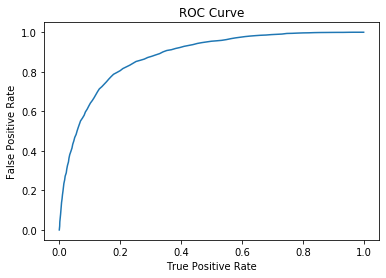

Training set areaUnderROC: 0.878699955894499


In [44]:
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(lr_model.summary.areaUnderROC))

In [45]:
lr_predictions = lr_model.transform(test)

In [46]:
lr_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+--------------------+--------------------+----------+-----+
|   selected_features|       rawPrediction|         probability|prediction|label|
+--------------------+--------------------+--------------------+----------+-----+
|(25,[2,4,6,8,10,1...|[-1.2355098670485...|[0.22521852529785...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[-0.1155322018374...|[0.47114903354941...|       1.0|  0.0|
|(25,[2,4,6,8,10,1...|[-0.0938336142293...|[0.47655879341067...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[-0.7928503563606...|[0.31155697054384...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[-0.6468332564292...|[0.34370351015203...|       1.0|  1.0|
|(25,[2,4,5,7,8,11...|[0.79698867082949...|[0.68932996039102...|       0.0|  0.0|
|(25,[2,4,6,8,19,2...|[-1.0735882760758...|[0.25472129241055...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[-1.0381228937166...|[0.26151234519206...|       1.0|  1.0|
|(25,[2,4,6,8,19,2...|[-1.4235702693195...|[0.19410248808551...|       1.0|  1.0|
|(25,[2,4,6,8,10

In [47]:
accuracy_m(lr_predictions)

Model accuracy: 78.383%


              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80      1159
         1.0       0.81      0.72      0.76      1043

    accuracy                           0.78      2202
   macro avg       0.79      0.78      0.78      2202
weighted avg       0.79      0.78      0.78      2202



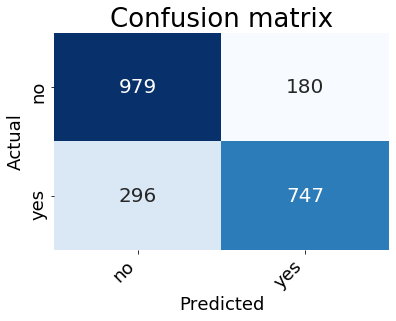

In [159]:
print_conf_matrix_and_report(lr_predictions)

Tuning regularization hyperparameter with cross-validation.

In [73]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.01, 0.1, 0.5])
             .build())
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)

In [85]:
best_lr_model = cvModel.bestModel
cv_lr_predictions = best_lr_model.transform(test)
acc = accuracy_m(cv_lr_predictions)
best_accuracies[type(best_lr_model).__name__] = acc

Model accuracy: 81.244%


              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      1159
         1.0       0.82      0.78      0.80      1043

    accuracy                           0.81      2202
   macro avg       0.81      0.81      0.81      2202
weighted avg       0.81      0.81      0.81      2202



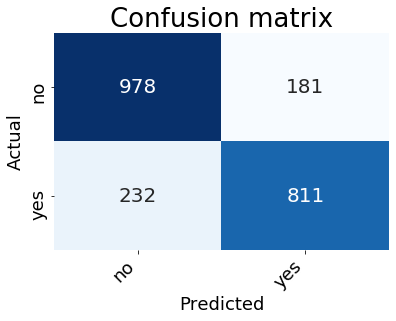

In [158]:
print_conf_matrix_and_report(cv_lr_predictions)

In [115]:
print('The best Logistic Regression CV regularization param: ' + str(cvModel.bestModel.getOrDefault('regParam')))

The best Logistic Regression CV regularization param: 0.0


## Decision Tree

In [97]:
dt = DecisionTreeClassifier(featuresCol = 'selected_features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

In [98]:
dt_predictions.select('selected_features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)

+--------------------+--------------+--------------------+----------+-----+
|   selected_features| rawPrediction|         probability|prediction|label|
+--------------------+--------------+--------------------+----------+-----+
|(25,[2,4,6,8,10,1...|[906.0,1419.0]|[0.38967741935483...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[2840.0,485.0]|[0.85413533834586...|       0.0|  0.0|
|(25,[2,4,6,8,10,1...|[2840.0,485.0]|[0.85413533834586...|       0.0|  1.0|
|(25,[2,4,6,8,10,1...|[906.0,1419.0]|[0.38967741935483...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[906.0,1419.0]|[0.38967741935483...|       1.0|  1.0|
|(25,[2,4,5,7,8,11...|[2840.0,485.0]|[0.85413533834586...|       0.0|  0.0|
|(25,[2,4,6,8,19,2...|[906.0,1419.0]|[0.38967741935483...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[906.0,1419.0]|[0.38967741935483...|       1.0|  1.0|
|(25,[2,4,6,8,19,2...|[471.0,2048.0]|[0.18697895990472...|       1.0|  1.0|
|(25,[2,4,6,8,10,1...|[2840.0,485.0]|[0.85413533834586...|       0.0|  0.0|
+-----------

In [99]:
accuracy_m(dt_predictions)

Model accuracy: 76.658%


0.7665758401453224

              precision    recall  f1-score   support

         0.0       0.85      0.68      0.75      1159
         1.0       0.71      0.86      0.78      1043

    accuracy                           0.77      2202
   macro avg       0.78      0.77      0.77      2202
weighted avg       0.78      0.77      0.77      2202



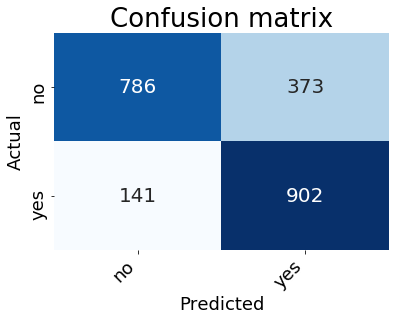

In [160]:
print_conf_matrix_and_report(dt_predictions)

In [125]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,3,4,5])
             .addGrid(dt.maxBins, [2, 4, 8])
             .build())
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)
dt_cvModel = cv.fit(train)

In [126]:
best_dt_model = dt_cvModel.bestModel
cv_dt_predictions = best_dt_model.transform(test)
acc = accuracy_m(cv_dt_predictions)
best_accuracies[type(best_dt_model).__name__] = acc

Model accuracy: 76.476%


              precision    recall  f1-score   support

         0.0       0.87      0.65      0.75      1159
         1.0       0.70      0.89      0.78      1043

    accuracy                           0.76      2202
   macro avg       0.78      0.77      0.76      2202
weighted avg       0.79      0.76      0.76      2202



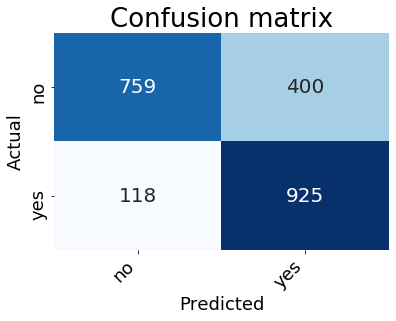

In [161]:
print_conf_matrix_and_report(cv_dt_predictions)

In [127]:
print('The best DecisionTree CV model max_depth param: ' + str(best_dt_model.getOrDefault('maxDepth'))\
       + ", maxBins: " + str(best_dt_model.getOrDefault('maxBins')))

The best DecisionTree CV model max_depth param: 4, maxBins: 8


## Summary

In [113]:
print_best_accuracies()

Best accuracies:
 - LogisticRegressionModel: 81.244%
 - DecisionTreeClassificationModel: 76.476%
